<a href="https://colab.research.google.com/github/jgloe/MRI_Classification/blob/main/MRI_Classification_multiple_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import cv2
import os
import tensorflow as tf
from tensorflow import keras

In [ ]:
#Now, let's link to your GoogleDrive. Run this cell and follow the authorization instructions:
#(We recommend putting a copy of the github repo in your google drive if you are using the demo "examples")

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_images_from_folder(folder, img_size):
    images = []
    for filename in os.listdir(folder):
        img = cv2.resize(cv2.imread(os.path.join(folder,filename)), (img_size, img_size))
        if img is not None:
            images.append(img)
    return images

In [ ]:
img_size = 227

glioma_train = load_images_from_folder('/content/drive/MyDrive/MRI_tumor_classification/Training/glioma_tumor', img_size)
meningioma_train = load_images_from_folder('/content/drive/MyDrive/MRI_tumor_classification/Training/meningioma_tumor', img_size)
pituitary_train = load_images_from_folder('/content/drive/MyDrive/MRI_tumor_classification/Training/pituitary_tumor', img_size)
control_train = load_images_from_folder('/content/drive/MyDrive/MRI_tumor_classification/Training/no_tumor', img_size)

glioma_test = load_images_from_folder('/content/drive/MyDrive/MRI_tumor_classification/Testing/glioma_tumor', img_size)
meningioma_test = load_images_from_folder('/content/drive/MyDrive/MRI_tumor_classification/Testing/meningioma_tumor', img_size)
pituitary_test = load_images_from_folder('/content/drive/MyDrive/MRI_tumor_classification/Testing/pituitary_tumor', img_size)
control_test = load_images_from_folder('/content/drive/MyDrive/MRI_tumor_classification/Testing/no_tumor', img_size)

In [ ]:
print('Number of glioma images in training set = ' + str(len(glioma_train)))
print('Number of meningioma images in training set = ' + str(len(meningioma_train)))
print('Number of pituitary images in training set = ' + str(len(pituitary_train)))
print('Number of control images in training set = ' + str(len(control_train)))

print('Number of glioma images in test set = ' + str(len(glioma_test)))
print('Number of meningioma images in test set = ' + str(len(meningioma_test)))
print('Number of pituitary images in test set = ' + str(len(pituitary_test)))
print('Number of control images in test set = ' + str(len(control_test)))

Number of glioma images in training set = 826
Number of meningioma images in training set = 822
Number of pituitary images in training set = 827
Number of control images in training set = 395
Number of glioma images in test set = 100
Number of meningioma images in test set = 115
Number of pituitary images in test set = 74
Number of control images in test set = 105


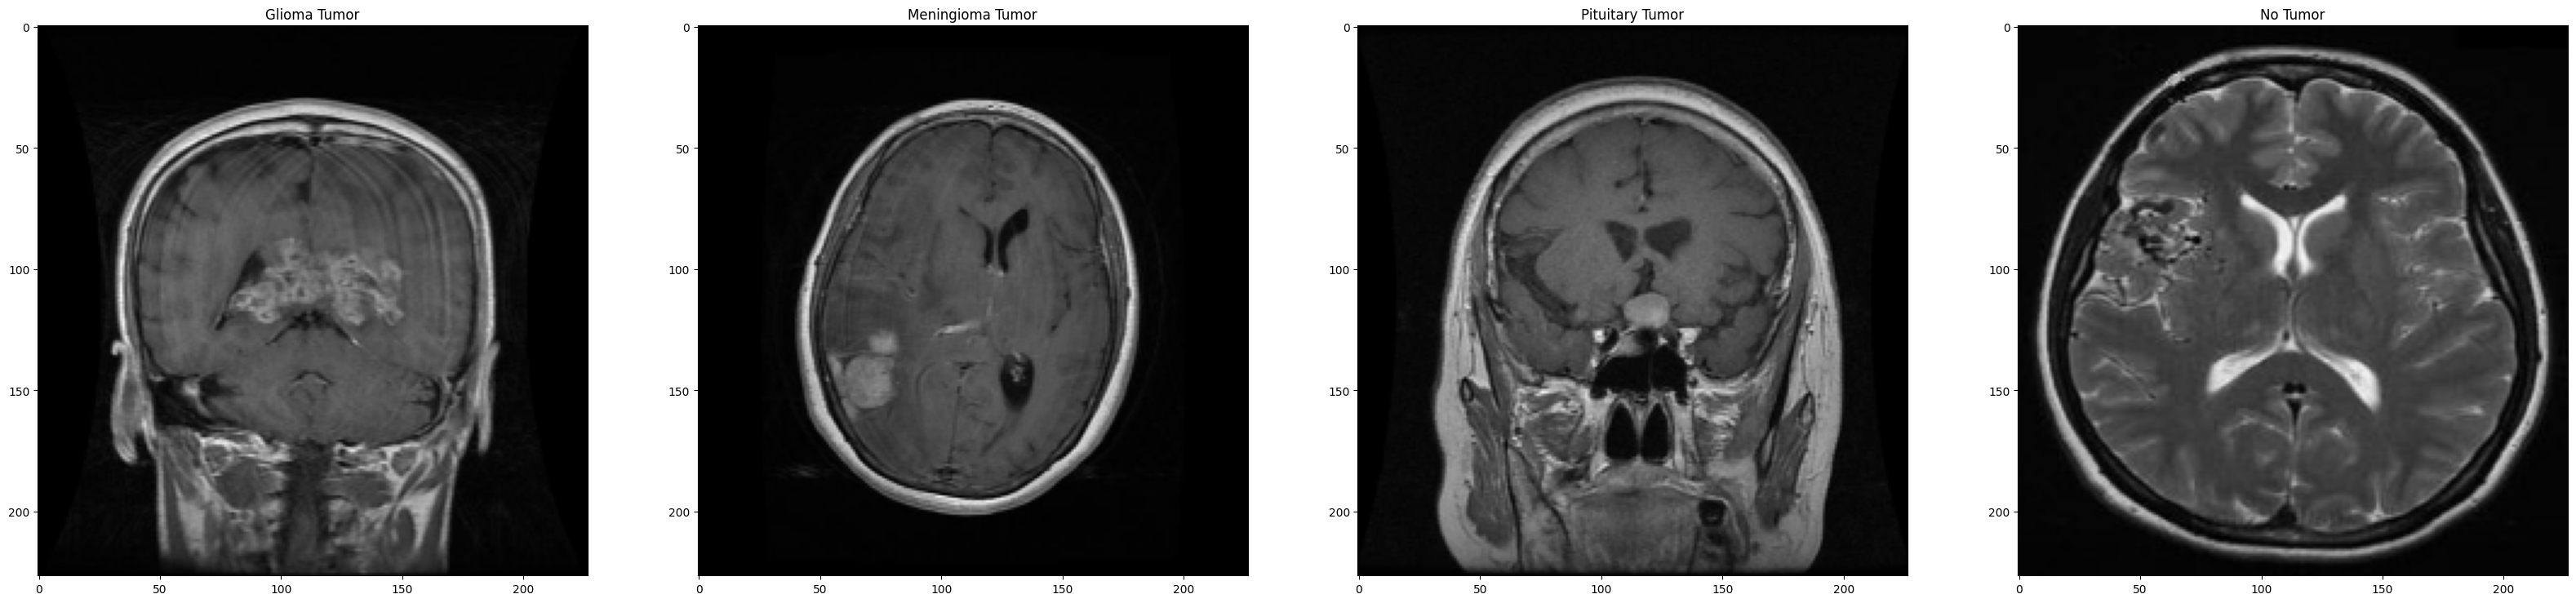

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(40, 40))
ax[0].imshow(glioma_train[0])
ax[0].title.set_text('Glioma Tumor')
ax[1].imshow(meningioma_train[0])
ax[1].title.set_text('Meningioma Tumor')
ax[2].imshow(pituitary_train[0])
ax[2].title.set_text('Pituitary Tumor')
ax[3].imshow(control_train[0])
ax[3].title.set_text('No Tumor')

In [ ]:
# convert to np.arrays for speed(?)
glioma_train = np.array(glioma_train)
meningioma_train = np.array(meningioma_train)
pituitary_train = np.array(pituitary_train)
control_train = np.array(control_train)

glioma_test = np.array(glioma_test)
meningioma_test = np.array(meningioma_test)
pituitary_test = np.array(pituitary_test)
control_test = np.array(control_test)

In [ ]:
# Scale the data to be between 0 and 1

glioma_train = glioma_train.astype('float32')
glioma_train = glioma_train / 255.0
meningioma_train = meningioma_train.astype('float32')
meningioma_train = meningioma_train / 255.0
pituitary_train = pituitary_train.astype('float32')
pituitary_train = pituitary_train / 255.0
control_train = control_train.astype('float32')
control_train = control_train / 255.0

glioma_test = glioma_test.astype('float32')
glioma_test = glioma_test / 255.0
meningioma_test = meningioma_test.astype('float32')
meningioma_test = meningioma_test / 255.0
pituitary_test = pituitary_test.astype('float32')
pituitary_test = pituitary_test / 255.0
control_test = control_test.astype('float32')
control_test = control_test / 255.0

In [ ]:
print(glioma_train.shape)
print(meningioma_train.shape)
print(pituitary_train.shape)
print(control_train.shape)

(826, 227, 227, 3)
(822, 227, 227, 3)
(827, 227, 227, 3)
(395, 227, 227, 3)


In [ ]:
mri_train = np.concatenate((glioma_train, meningioma_train, pituitary_train, control_train), axis=0)
mri_test = np.concatenate((glioma_test, meningioma_test, pituitary_test, control_test), axis=0)

In [ ]:
print('Shape of training set = ' + str(mri_train.shape))
print('Shape of test set = ' + str(mri_test.shape))

Shape of training set = (2870, 227, 227, 3)
Shape of test set = (394, 227, 227, 3)


In [ ]:
mri_train_labels = np.zeros(len(mri_train))
mri_train_labels[len(glioma_train):len(glioma_train) + len(meningioma_train)] = 1
mri_train_labels[len(glioma_train) + len(meningioma_train):len(glioma_train) + len(meningioma_train) + len(pituitary_train)] = 2
mri_train_labels[len(glioma_train) + len(meningioma_train) + len(pituitary_train):] = 3

In [ ]:
mri_test_labels = np.zeros(len(mri_test))
mri_test_labels[len(glioma_test):len(glioma_test) + len(meningioma_test)] = 1
mri_test_labels[len(glioma_test) + len(meningioma_test):len(glioma_test) + len(meningioma_test) + len(pituitary_test)] = 2
mri_test_labels[len(glioma_test) + len(meningioma_test) + len(pituitary_test):] = 3

In [ ]:
X_tt, X_ho, y_tt, y_ho = train_test_split(mri_train.copy(), mri_train_labels, test_size=.1, random_state=400, shuffle=True, stratify=mri_train_labels)


In [ ]:
# Implementation of AlexNet

alexnet = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

In [ ]:
alexnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

In [ ]:
# Compile the neural network
alexnet.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
# Train the model
n_epochs = 25
history_alex = alexnet.fit(X_tt,
                            y_tt,
                            epochs = n_epochs,
                            batch_size = 32,
                            validation_data = (X_ho,y_ho))

Epoch 1/25
81/81 [==============================] - 20s 85ms/step - loss: 1.8212 - accuracy: 0.5215 - val_loss: 1.4180 - val_accuracy: 0.2892
Epoch 2/25
81/81 [==============================] - 4s 53ms/step - loss: 1.1295 - accuracy: 0.6345 - val_loss: 1.5417 - val_accuracy: 0.3066
Epoch 3/25
81/81 [==============================] - 5s 56ms/step - loss: 0.8749 - accuracy: 0.6872 - val_loss: 1.7112 - val_accuracy: 0.3449
Epoch 4/25
81/81 [==============================] - 4s 54ms/step - loss: 0.7443 - accuracy: 0.7263 - val_loss: 1.5247 - val_accuracy: 0.3937
Epoch 5/25
81/81 [==============================] - 4s 52ms/step - loss: 0.6613 - accuracy: 0.7538 - val_loss: 1.1158 - val_accuracy: 0.5505
Epoch 6/25
81/81 [==============================] - 4s 54ms/step - loss: 0.5639 - accuracy: 0.7855 - val_loss: 0.6938 - val_accuracy: 0.7073
Epoch 7/25
81/81 [==============================] - 4s 52ms/step - loss: 0.4984 - accuracy: 0.8087 - val_loss: 0.5177 - val_accuracy: 0.7944
Epoch 8/25
8

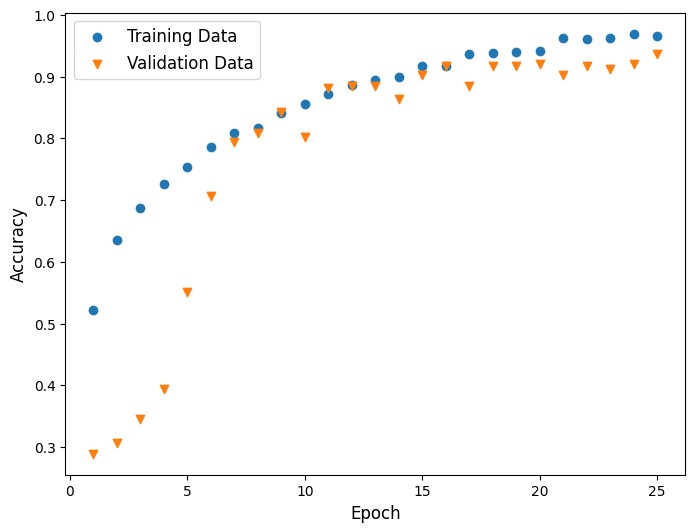

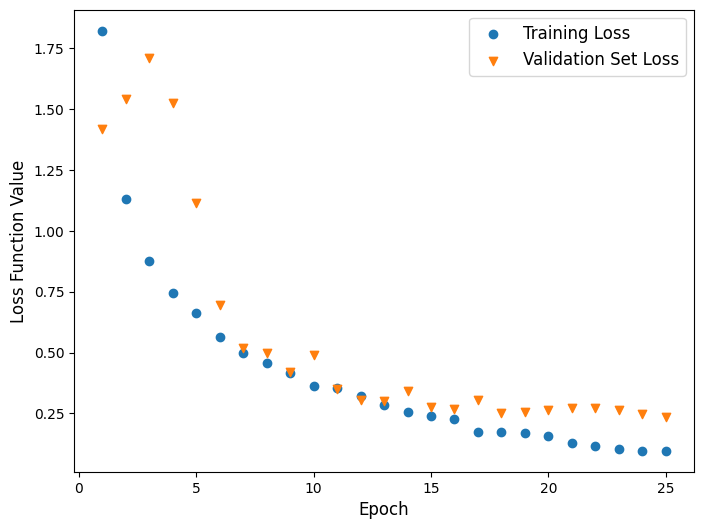

In [ ]:
plt.figure(figsize=(8,6))

plt.scatter(range(1,n_epochs+1), 
            history_alex.history['accuracy'], 
            label="Training Data")
plt.scatter(range(1,n_epochs+1), 
            history_alex.history['val_accuracy'], 
            marker='v',
            label="Validation Data")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)


plt.legend(fontsize=12)


plt.show()

plt.figure(figsize = (8,6))

plt.scatter(range(1,n_epochs+1), history_alex.history['loss'], label = "Training Loss")
plt.scatter(range(1,n_epochs+1), history_alex.history['val_loss'], marker='v', label = "Validation Set Loss")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss Function Value", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()

In [ ]:
# Test accuracy of validation set
np.round(100*accuracy_score(y_ho, np.argmax(alexnet.predict(X_ho), axis=1)),2)

9/9 [==============================] - 0s 26ms/step


93.73

Should we implement a dropout layer?


Are we over-fitting? And if so, try to minimize overfitting.


Using a T4 GPU on Google Colab Pro, our training took: 4m08s


Our training dataset comprises: 2874 images


Whereas our testing dataset includes: 398 images

From ---> TF Hub for TF2: Retraining an image classifier
https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb#scrollTo=FlsEcKVeuCnf

In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.12.0
Hub version: 0.13.0
GPU is available


In [133]:
#@title

model_name = "efficientnetv2-xl-21k" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 9#@param {type:"integer"}

Selected model: efficientnetv2-xl-21k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2
Input size (512, 512)


In [ ]:
# data_dir = tf.keras.utils.get_file(
#     'flower_photos',
#     'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#     untar=True)

In [134]:
import pathlib
data_dir = pathlib.Path('/content/drive/MyDrive/MRI_tumor_classification/Training/') 
# count = len(list(data_dir.glob('*.jpg')))
# count

In [135]:
# Data Augmentation

def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.


## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [136]:
do_fine_tuning = False #@param {type:"boolean"}

In [140]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.BatchNormalization(), #stabilizes the learning process and dramatically reduces the number of training epochs required
    tf.keras.layers.Dense(128, activation='relu'),  # Additional Dense layer
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),  # Additional Dense layer
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)) #increased regularization rate from 0.0001
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_9 (KerasLayer)  (None, 1280)              207615832 
                                                                 
 dropout_11 (Dropout)        (None, 1280)              0         
                                                                 
 batch_normalization_8 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_17 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_9 (Batc  (None, 128)              512       
 hNormalization)                                                 
                 

## Training the model

In [141]:
# model.compile(
#   optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0), 
#   loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), # label_smoothing=0.1 ##remove label smoothing to improve speed. This helps with overfitting in some cases by encouraging model to be less confident in its predictions.
#   metrics=['accuracy'])

# try Adam optimizer -- this might be able to converge faster or find better minima than plain SDG

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Changed optimizer to Adam
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.05),  # Reduced label smoothing
    metrics=['accuracy', 'Precision', 'Recall']  # Added additional metrics -- Precision and Recall will be useful for imbalanced datasets, or if false positives have a negative outcome
)


In [ ]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=10, steps_per_epoch=steps_per_epoch, #change epochs from 5 to 10.
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/10
255/255 [==============================] - 307s 1s/step - loss: 1.1065 - accuracy: 0.5974 - precision: 0.4716 - recall: 0.7120 - val_loss: 0.6607 - val_accuracy: 0.8060 - val_precision: 0.6476 - val_recall: 0.8977
Epoch 2/10
169/255 [==================>...........] - ETA: 1:25 - loss: 0.9068 - accuracy: 0.6689 - precision: 0.5090 - recall: 0.7878

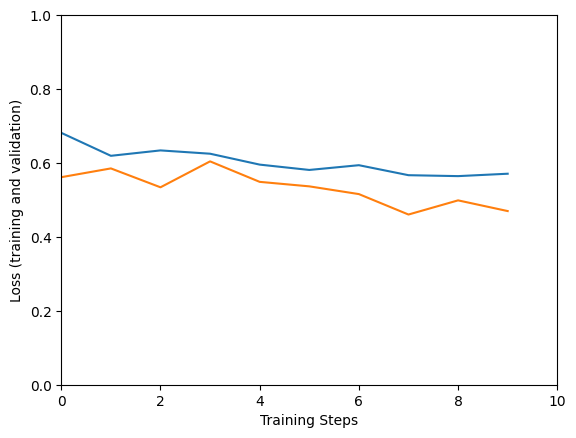

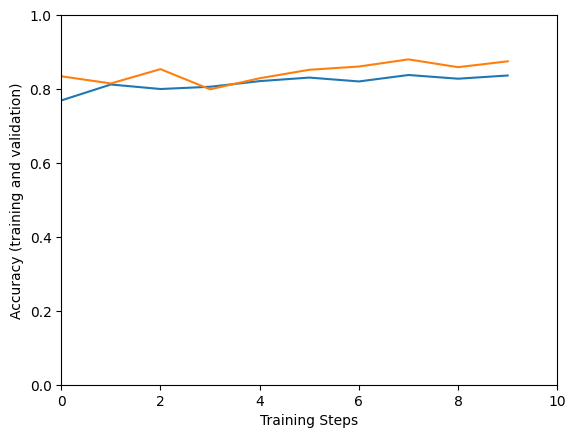

In [132]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.xlim([0,10])
plt.ylim([0,1])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.xlim([0,10])
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

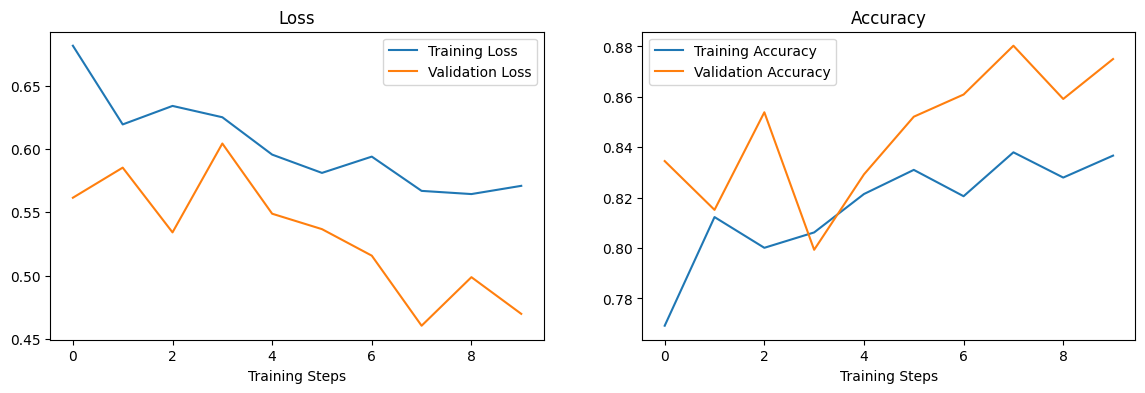

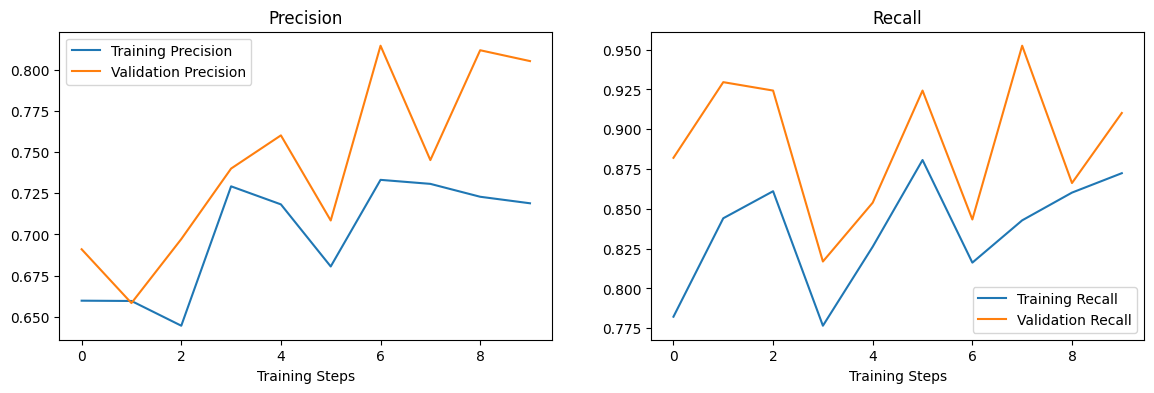

In [117]:
# Plotting loss
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='Training Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.xlabel("Training Steps")
plt.legend()
plt.title('Loss')

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(hist['accuracy'], label='Training Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Training Steps")
plt.legend()
plt.title('Accuracy')
plt.show()

# Plotting precision
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(hist['precision'], label='Training Precision')
plt.plot(hist['val_precision'], label='Validation Precision')
plt.xlabel("Training Steps")
plt.legend()
plt.title('Precision')

# Plotting recall
plt.subplot(1, 2, 2)
plt.plot(hist['recall'], label='Training Recall')
plt.plot(hist['val_recall'], label='Validation Recall')
plt.xlabel("Training Steps")
plt.legend()
plt.title('Recall')
plt.show()

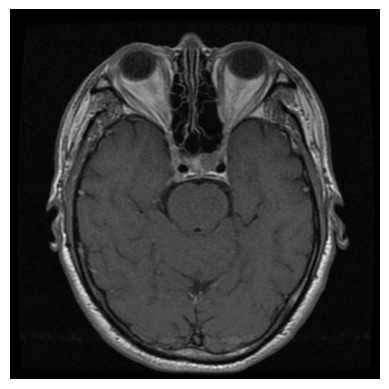

1/1 [==============================] - 0s 57ms/step
True label: pituitary_tumor
Predicted label: pituitary_tumor


In [127]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

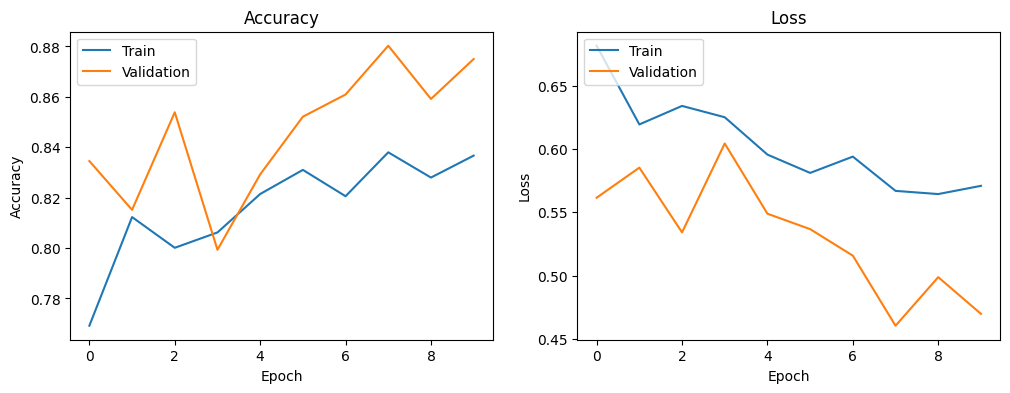

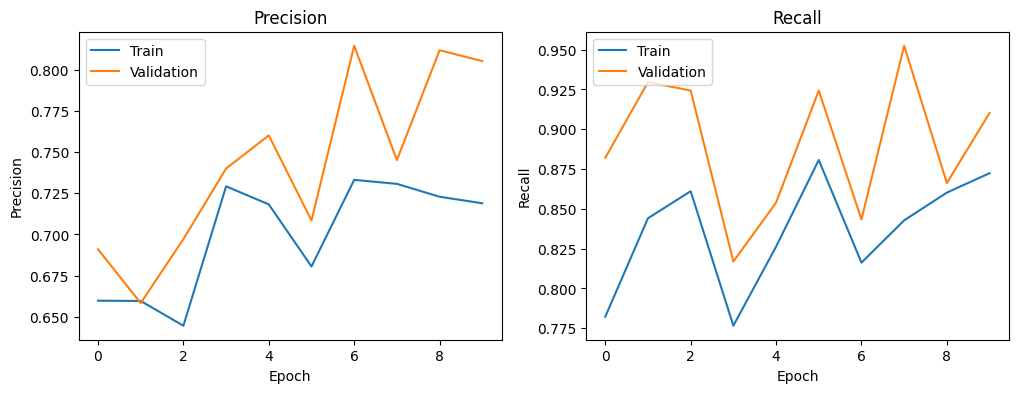

In [129]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.savefig("accuracy_loss.png")

# Plot training & validation precision values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(hist['precision'])
plt.plot(hist['val_precision'])
plt.title('Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation recall values
plt.subplot(1, 2, 2)
plt.plot(hist['recall'])
plt.plot(hist['val_recall'])
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.savefig("precision_recall.png")

## Compare all models and how they perform on the classification task.

Work on this: 

In [ ]:
ProjectFolderName = 'MRI_tumor_classification'

training_file_path = ['/content/drive/My Drive/'+ProjectFolderName+'/Training/']
testing_file_path = ['/content/drive/My Drive/'+ProjectFolderName+'/Testing/']

glioma_train_path = ['/content/drive/My Drive/'+ProjectFolderName+'/Training/glioma_tumor/']
meningioma_train_path = ['/content/drive/My Drive/'+ProjectFolderName+'/Training/meningioma_tumor/']
pituitary_train_path = ['/content/drive/My Drive/'+ProjectFolderName+'/Training/pituitary_tumor/']
control_train_path = ['/content/drive/My Drive/'+ProjectFolderName+'/Training/control_tumor/']

glioma_test_path = ['/content/drive/My Drive/'+ProjectFolderName+'/Testing/glioma_tumor/']
meningioma_test_path = ['/content/drive/My Drive/'+ProjectFolderName+'/Testing/meningioma_tumor/']
pituitary_test_path = ['/content/drive/My Drive/'+ProjectFolderName+'/Testing/pituitary_tumor/']
control_test_path = ['/content/drive/My Drive/'+ProjectFolderName+'/Testing/control_tumor/']


In [ ]:
print('Number of glioma images in training set = ' + str(len(glioma_train_path)))
print('Number of meningioma images in training set = ' + str(len(meningioma_train_path)))
print('Number of pituitary images in training set = ' + str(len(pituitary_train_path)))
print('Number of control images in training set = ' + str(len(control_train_path)))

print('Number of glioma images in test set = ' + str(len(glioma_test_path)))
print('Number of meningioma images in test set = ' + str(len(meningioma_test_path)))
print('Number of pituitary images in test set = ' + str(len(pituitary_test_path)))
print('Number of control images in test set = ' + str(len(control_test_path)))

Number of glioma images in training set = 1
Number of meningioma images in training set = 1
Number of pituitary images in training set = 1
Number of control images in training set = 1
Number of glioma images in test set = 1
Number of meningioma images in test set = 1
Number of pituitary images in test set = 1
Number of control images in test set = 1


In [ ]:
# Load your data

# Assume x_train, y_train, x_test, y_test are prepared

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

In [ ]:
# Define models
def create_model(base_model):
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

base_models = [VGG16, ResNet50, InceptionV3, MobileNet]
models = []

for base_model in base_models:
    base_model = base_model(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    models.append(create_model(base_model))

In [ ]:
# Train and evaluate each model
for i, model in enumerate(models):
    print(f"Training model {i+1}")
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[Precision(), Recall(), Accuracy()])
    model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=10, validation_data=(x_test, y_test))
    
    print(f"Evaluating model {i+1}")
    y_pred = model.predict(x_test)
    y_pred = [1 if p > 0.5 else 0 for p in y_pred]  # Convert probabilities to class labels
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
